## Exploratory Data Analysis is performed in the first part of this notebook.
## Later RNN is used for classification of reviews.

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import nltk
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.tokenize import RegexpTokenizer
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import re
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN

import os



In [2]:
df = pd.read_csv("../datasets/clothing.csv",index_col=0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
df.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,918.118709,43.198544,4.196032,0.822362,2.535936
std,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


# EDA - What can you Explore?
- what age gives what type of rating?
- What are recommended in each Division, Class, department of Clothes?
- Which age group gives more comments/ratings on what type of clothes?
- Rating vs Positive feedback count
- Lengthy Reviews for what type of cloth?
- Positive/Negative Reviews for what type of clothes?


## What age group has given what types of Ratings?

Text(0.5, 1.0, 'Age Distribution in Data')

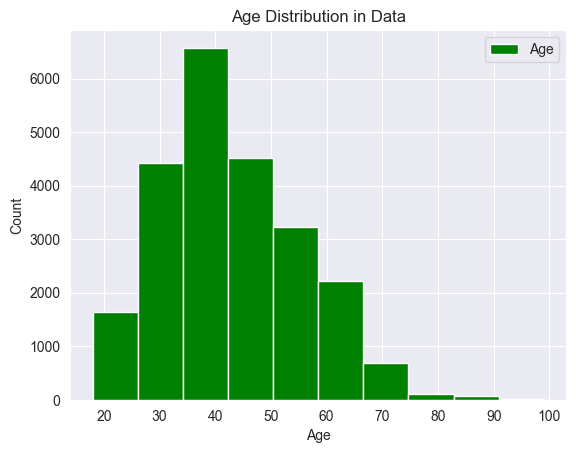

In [5]:
# The age distribution in data
plt.hist(df['Age'], color="green", label = "Age")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution in Data")

<Axes: xlabel='Rating', ylabel='Age'>

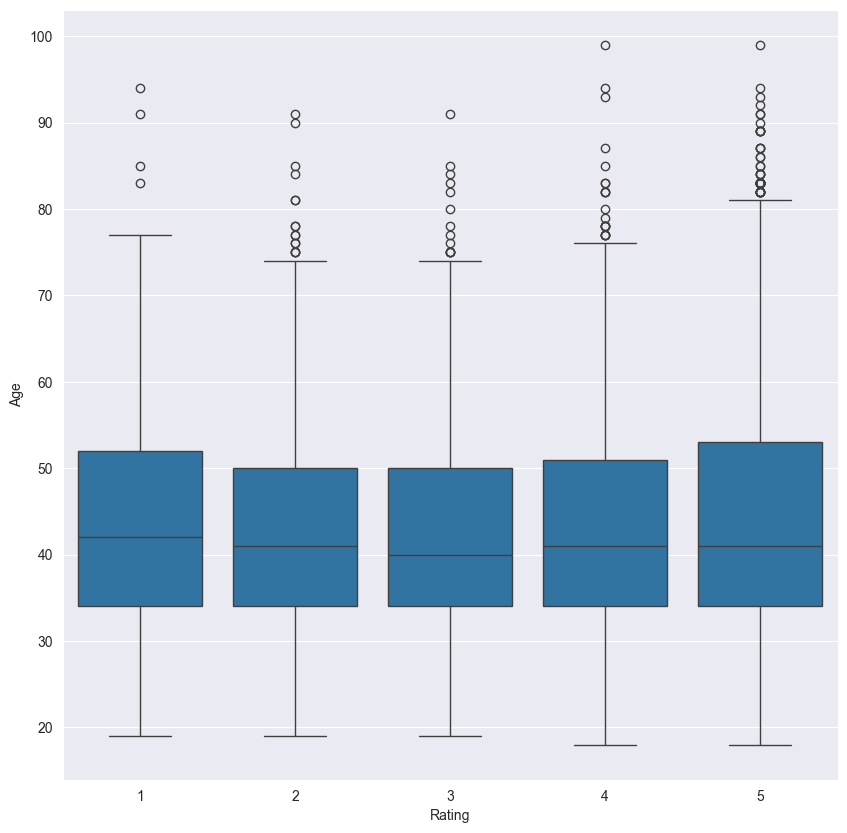

In [6]:
plt.figure(figsize=(10,10))
sns.boxplot(x = 'Rating', y = 'Age', data = df)

## What are Recommended Clothes item?

In [7]:
print(df['Division Name'].unique())
print(df['Department Name'].unique())
print(df['Class Name'].unique())

['Initmates' 'General' 'General Petite' nan]
['Intimate' 'Dresses' 'Bottoms' 'Tops' 'Jackets' 'Trend' nan]
['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' nan 'Chemises']


In [8]:
rd = df[df['Recommended IND'] == 1] # recommended
nrd = df[df['Recommended IND'] == 0] # not recommended
rd.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits


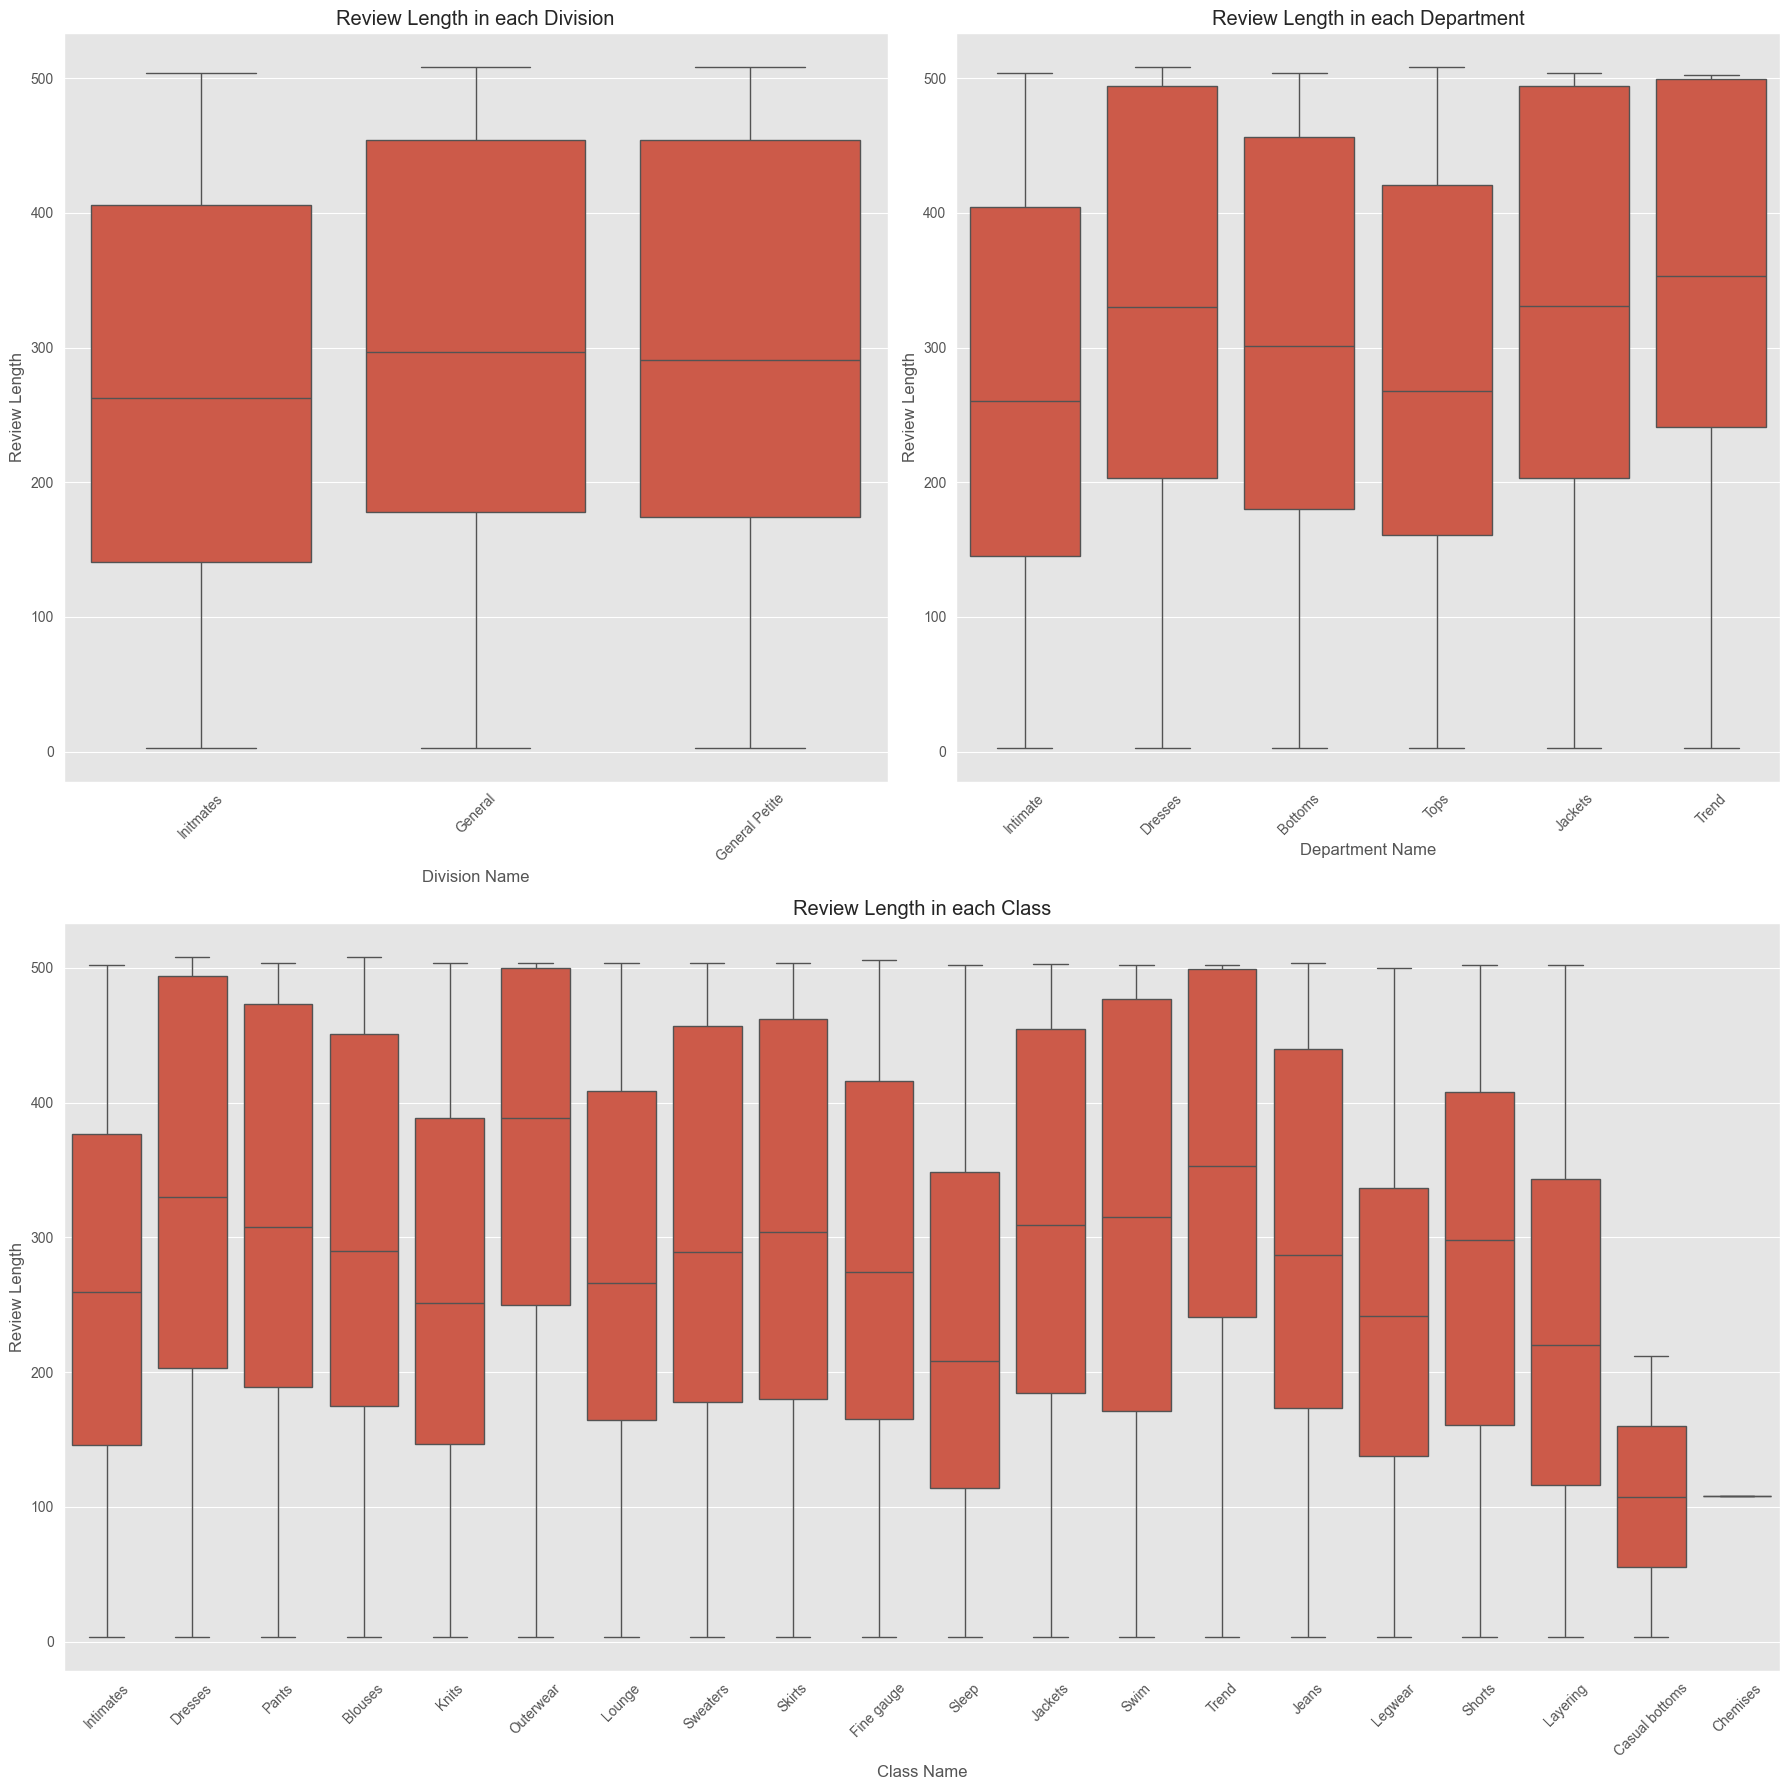

In [9]:
# Calculate Review Length
df['Review Length'] = df['Review Text'].apply(lambda x: len(str(x)))

plt.style.use('ggplot')

fig = plt.figure(figsize=(18, 18))

# Plot 1: Review Length in each Division
ax1 = plt.subplot2grid((2, 2), (0, 0))
sns.boxplot(x='Division Name', y='Review Length', data=df, ax=ax1)
ax1.set_title("Review Length in each Division")
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Review Length in each Department
ax2 = plt.subplot2grid((2, 2), (0, 1))
sns.boxplot(x='Department Name', y='Review Length', data=df, ax=ax2)
ax2.set_title("Review Length in each Department")
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Review Length in each Class
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
sns.boxplot(x='Class Name', y='Review Length', data=df, ax=ax3)
ax3.set_title("Review Length in each Class")
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Which age group gives what length of comments on what type of clothes?

In [10]:
df['Review Length'] = df['Review Text'].astype(str).apply(len)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,53
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,303
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,500
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,124
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,192


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1976\3629770225.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df['Review Length'], color="blue")


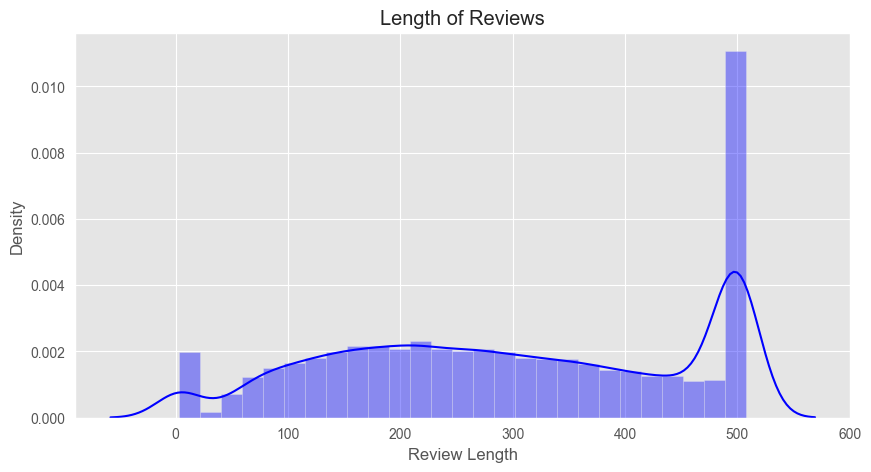

In [11]:
fig = plt.figure(figsize=(10, 5))
#ax1 = plt.hist(df['Review Length'], color = "red", bins = 20)
ax = sns.distplot(df['Review Length'], color="blue")
ax = plt.title("Length of Reviews")

<Axes: xlabel='Age', ylabel='Review Length'>

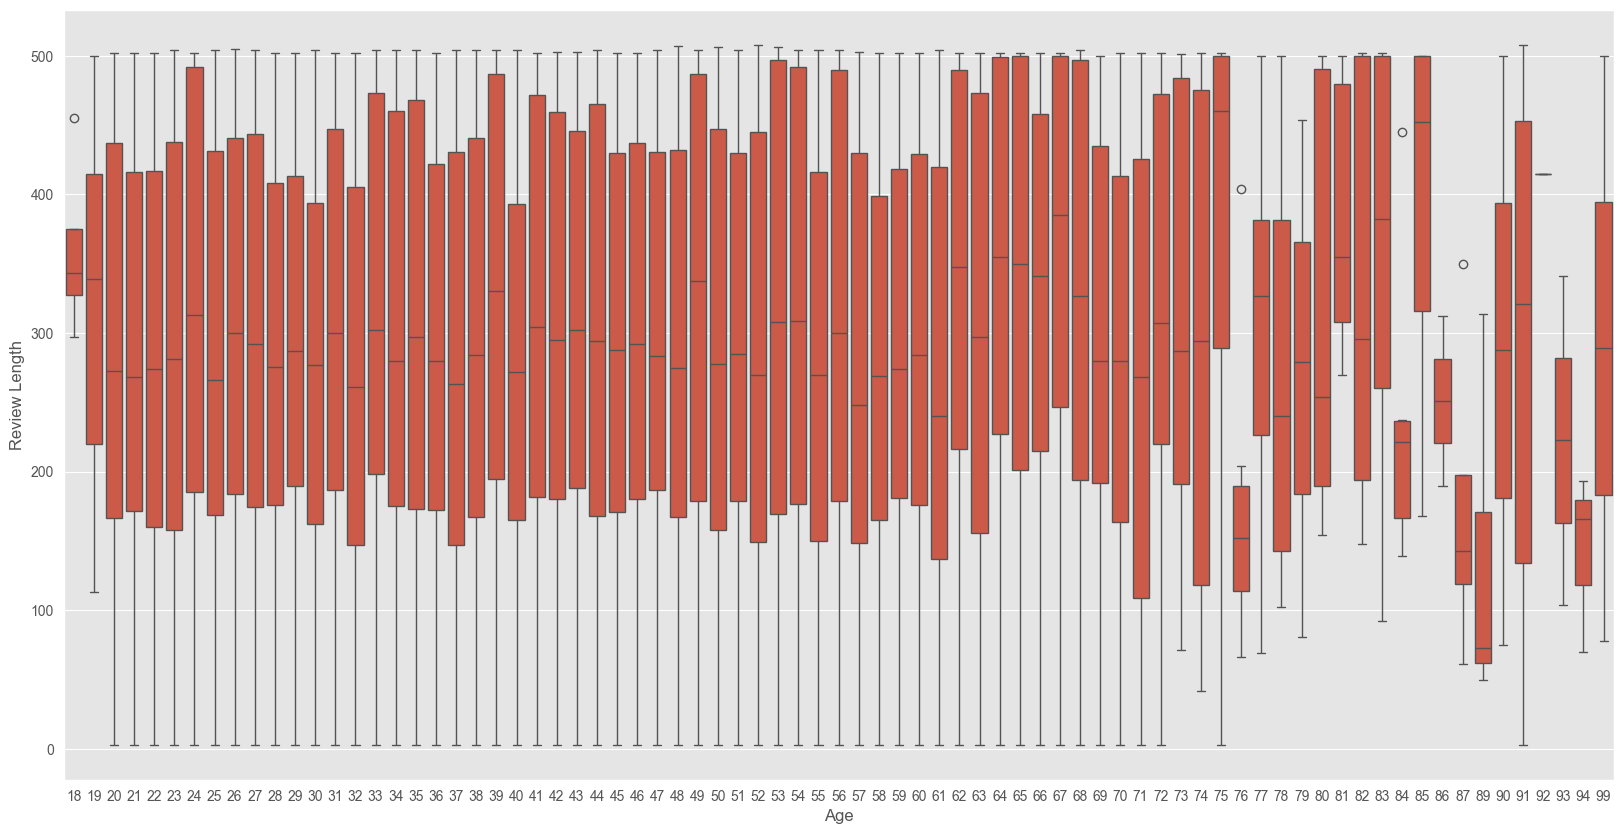

In [12]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'Age', y = 'Review Length', data = df)

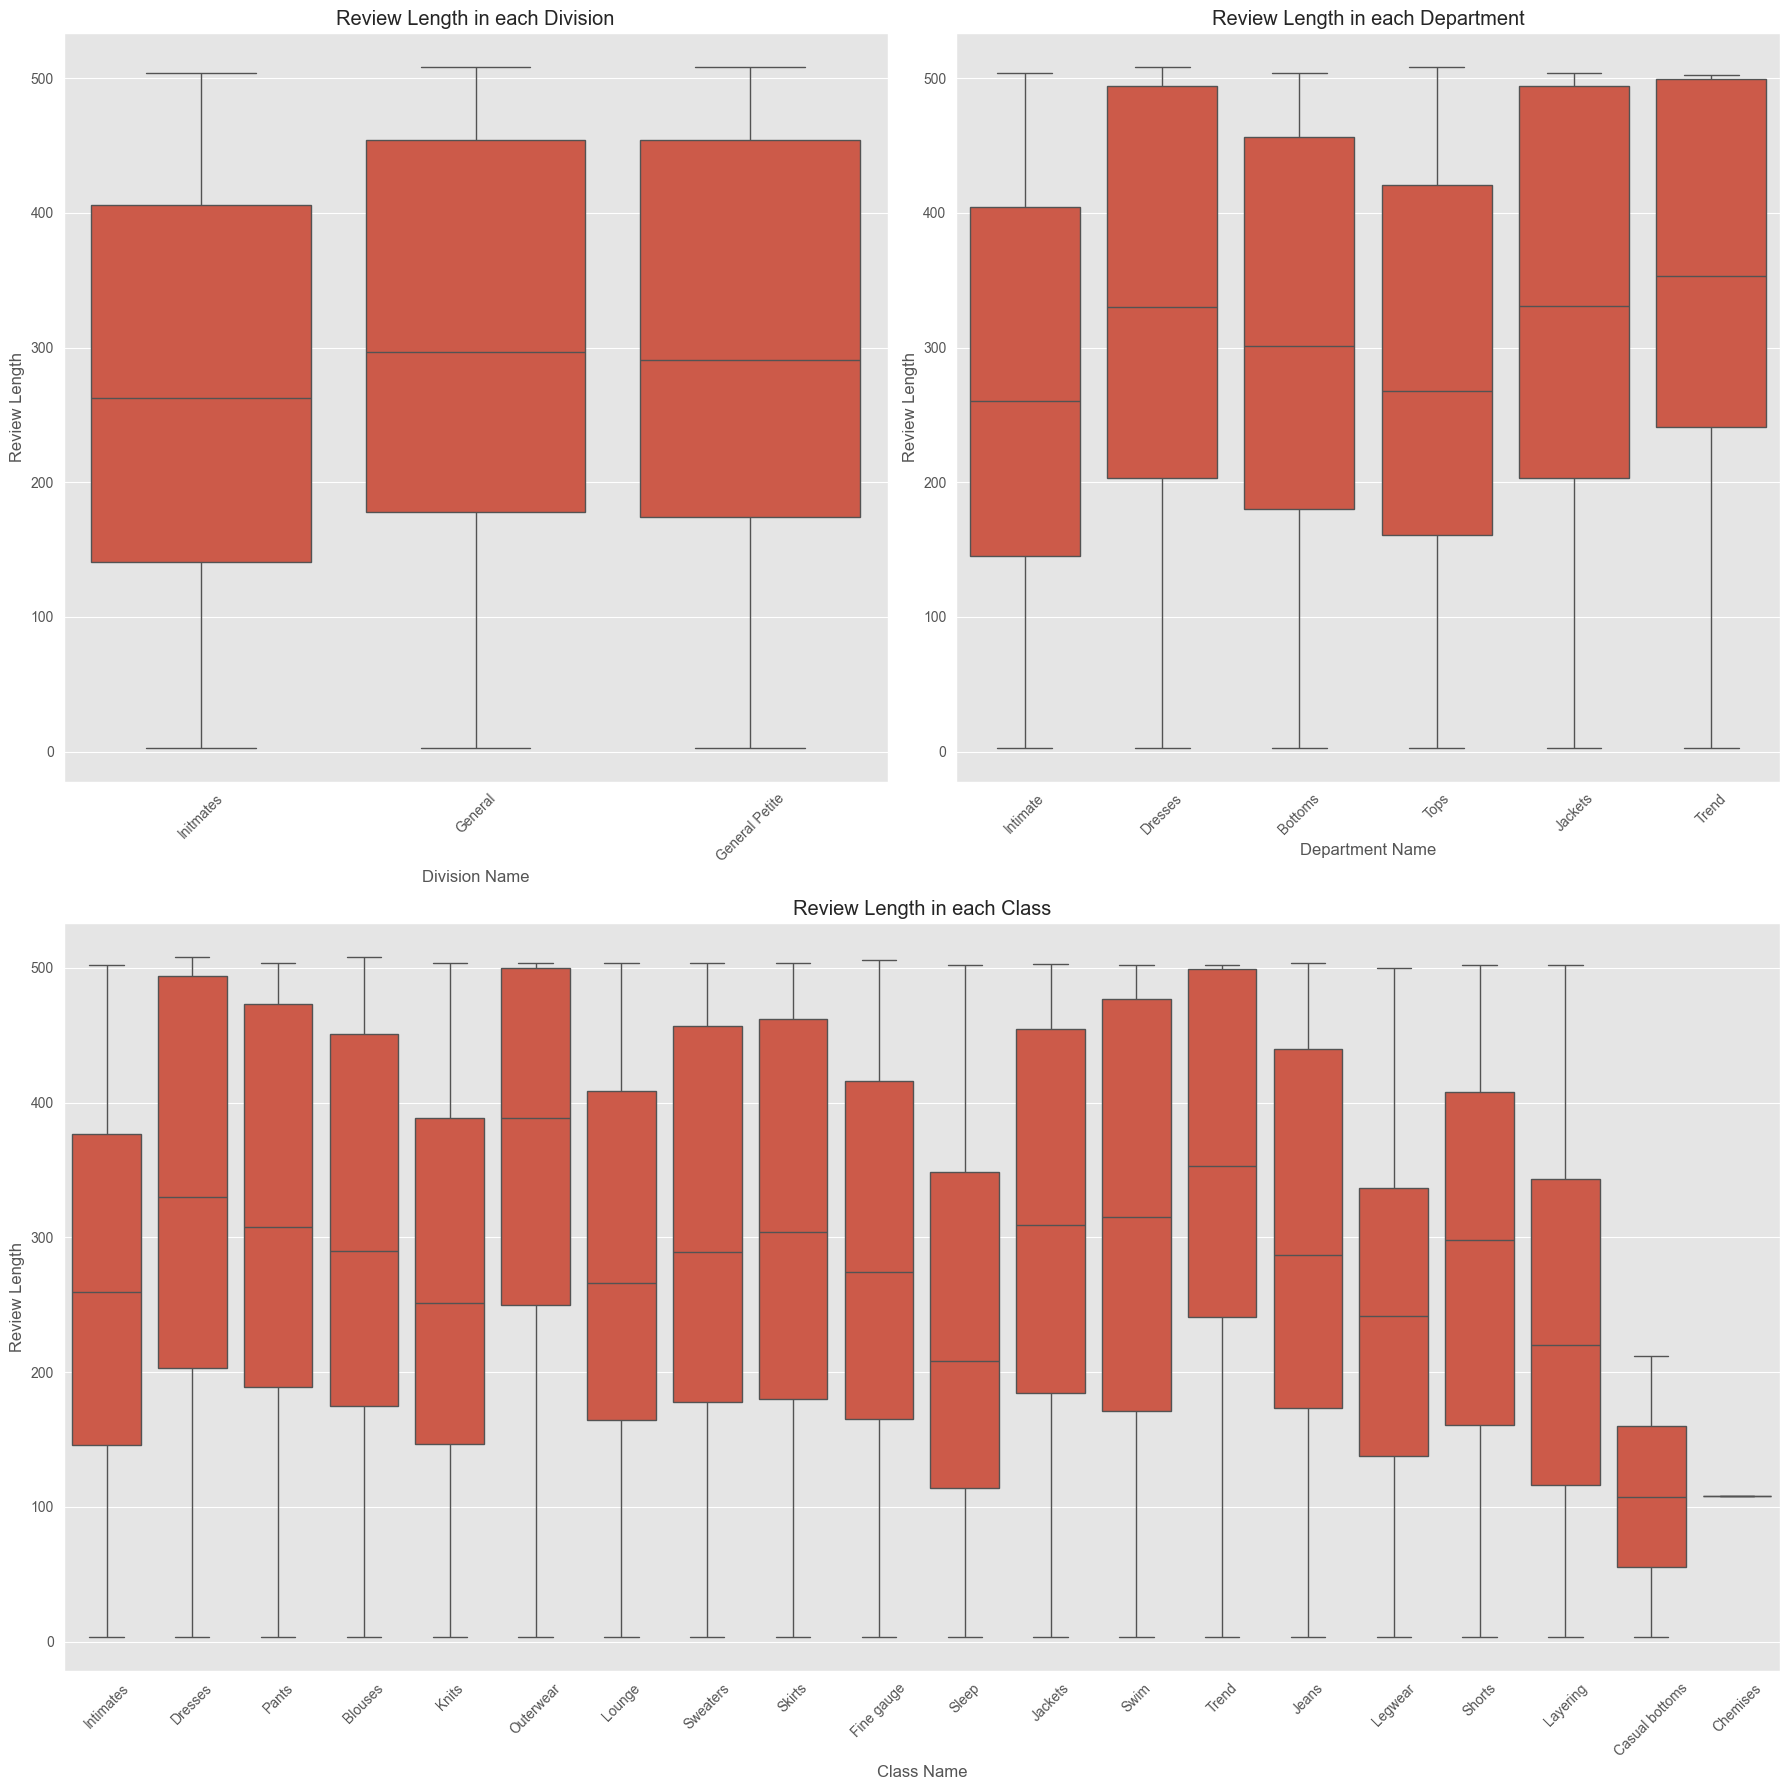

In [13]:
# Calculate Review Length
df['Review Length'] = df['Review Text'].apply(lambda x: len(str(x)))

plt.style.use('ggplot')

fig = plt.figure(figsize=(18, 18))

# Plot 1: Review Length in each Division
ax1 = plt.subplot2grid((2, 2), (0, 0))
sns.boxplot(x='Division Name', y='Review Length', data=df, ax=ax1)
ax1.set_title("Review Length in each Division")
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Review Length in each Department
ax2 = plt.subplot2grid((2, 2), (0, 1))
sns.boxplot(x='Department Name', y='Review Length', data=df, ax=ax2)
ax2.set_title("Review Length in each Department")
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Review Length in each Class
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
sns.boxplot(x='Class Name', y='Review Length', data=df, ax=ax3)
ax3.set_title("Review Length in each Class")
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Ratings vs. Positive Feedback Count

<Axes: xlabel='Rating', ylabel='Positive Feedback Count'>

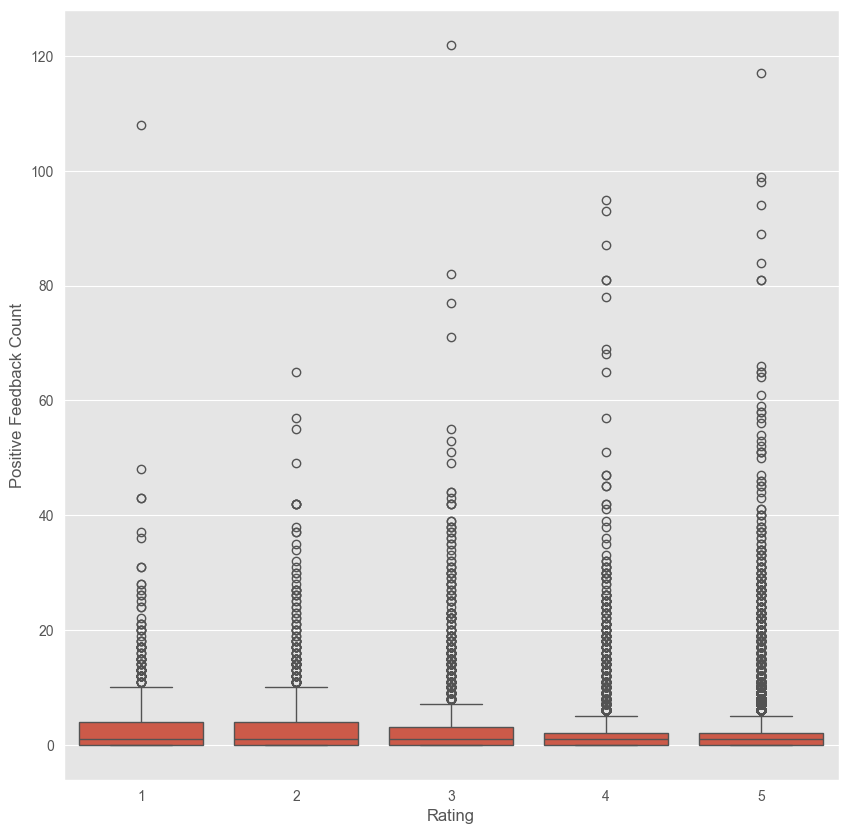

In [14]:
plt.figure(figsize=(10,10))
sns.boxplot(x = 'Rating', y = 'Positive Feedback Count', data = df)

# Review Analysis

In [15]:
ps = PorterStemmer()
Reviews = df['Review Text'].astype(str)
print(Reviews.shape)
Reviews[Reviews.isnull()] = "NULL"

(23486,)


In [16]:
tokenizer = RegexpTokenizer(r'[a-zA-Z]{3,}')
stop_words = set(stopwords.words('english'))

In [17]:
df['tokenized'] = df["Review Text"].astype(str).str.lower() # Turn into lower case text
df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # Apply tokenize to each row
df['tokenized'] = df['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # Remove stopwords from each row


In [18]:
def string_unlist(strlist):
    return " ".join(strlist)

df["tokenized_unlist"] = df["tokenized"].apply(string_unlist)
df.head()


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length,tokenized,tokenized_unlist
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,53,"[absolutely, wonderful, silky, sexy, comfortable]",absolutely wonderful silky sexy comfortable
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,303,"[love, dress, sooo, pretty, happened, find, st...",love dress sooo pretty happened find store gla...
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,500,"[high, hopes, dress, really, wanted, work, ini...",high hopes dress really wanted work initially ...
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,124,"[love, love, love, jumpsuit, fun, flirty, fabu...",love love love jumpsuit fun flirty fabulous ev...
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,192,"[shirt, flattering, due, adjustable, front, ti...",shirt flattering due adjustable front tie perf...


### Sentiment Analysis

In [19]:
# Pre-Processing
SIA = SentimentIntensityAnalyzer()

# Applying Model, Variable Creation
df['Polarity Score']=df["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["tokenized_unlist"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0,'Sentiment']='Positive'
df.loc[df['Polarity Score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0,'Sentiment']='Negative'

In [20]:
conditions = [
    df['Sentiment'] == "Positive",
    df['Sentiment'] == "Negative",
    df['Sentiment'] == "Neutral"]
choices = [1,-1,0]
df['label'] = np.select(conditions, choices)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length,tokenized,tokenized_unlist,Polarity Score,Neutral Score,Negative Score,Positive Score,Sentiment,label
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,53,"[absolutely, wonderful, silky, sexy, comfortable]",absolutely wonderful silky sexy comfortable,0.8991,0.154,0.000,0.846,Positive,1
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,303,"[love, dress, sooo, pretty, happened, find, st...",love dress sooo pretty happened find store gla...,0.9710,0.468,0.000,0.532,Positive,1
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,500,"[high, hopes, dress, really, wanted, work, ini...",high hopes dress really wanted work initially ...,0.8779,0.721,0.040,0.240,Positive,1
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,124,"[love, love, love, jumpsuit, fun, flirty, fabu...",love love love jumpsuit fun flirty fabulous ev...,0.9464,0.185,0.171,0.644,Positive,1
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,192,"[shirt, flattering, due, adjustable, front, ti...",shirt flattering due adjustable front tie perf...,0.9062,0.494,0.000,0.506,Positive,1


### Simple Embedding Deep Neural Network

In [21]:
samples = df["tokenized_unlist"].tolist()
maxlen = 100 
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 13241 unique tokens.


In [22]:
labels = np.asarray(df["label"].values)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (23486, 100)
Shape of label tensor: (23486,)


In [23]:
indices = np.arange(df.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [24]:
training_samples = 11743
validation_samples = 17614
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: validation_samples] 
y_val = labels[training_samples: validation_samples]
x_test = data[validation_samples:]
y_test = labels[validation_samples:]
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

##### Baseline for Sentiment Analysis

In [25]:
# BASELINE
# That is, if all the labels are predicted as 1
(np.sum(df['label'] == 1)/df.shape[0]) * 100

# we have to make model that performs better than this baseline

93.12782082943029

In [26]:
def build_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
    return model

In [27]:
model = build_model()
model.summary()
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save("model1.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1642177 (6.26 MB)
Trainable params: 1642177 (6.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
367/367 

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


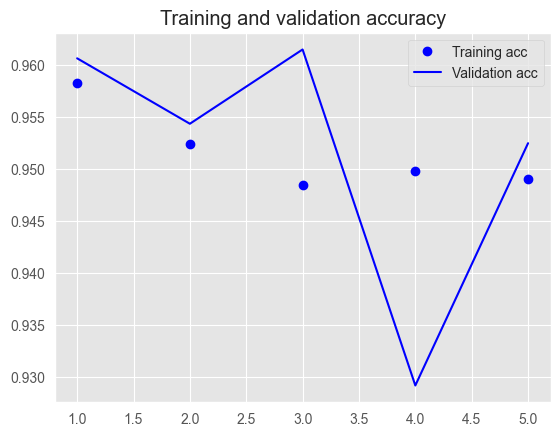

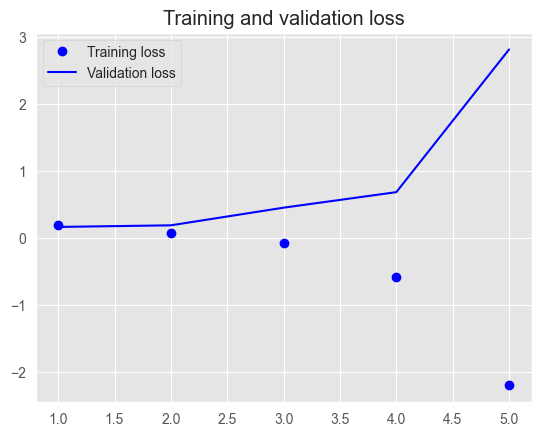

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [29]:
model.evaluate(x_test, y_test)

184/184 [==============================] - 1s 3ms/step - loss: 2.2886 - acc: 0.9525


[2.2886226177215576, 0.9524863958358765]

### RNN

In [30]:
def build_RNN():
    model = Sequential() 
    model.add(Embedding(max_words, 100, input_length=maxlen)) 
    #model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32)) 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
    return model

In [31]:
model = build_RNN()
model.summary()
history_RNN = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save("model_RNN.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1004289 (3.83 MB)
Trainable params: 1004289 (3.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
367/367 [==============================] - 12s 28ms/step - loss: 0.2366 - acc: 0.9508 - val_loss: 0.1817 - val_acc: 0.9591
Epoch 2/5
367/367 [==============================] - 10s 27ms/step - loss: 0.1350 - acc: 0.9589 - val_loss: 0.1532 - val_acc: 0.9489
Epoch 3/5
367/

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


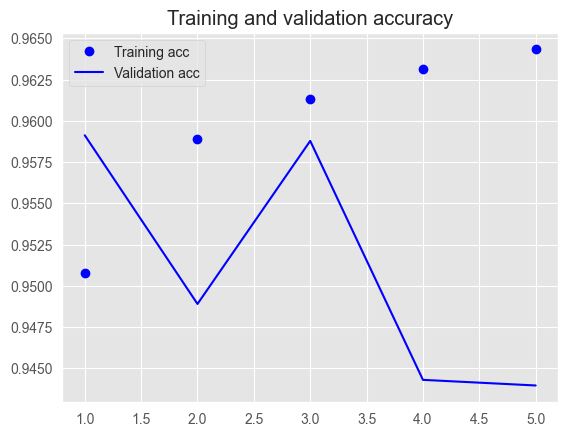

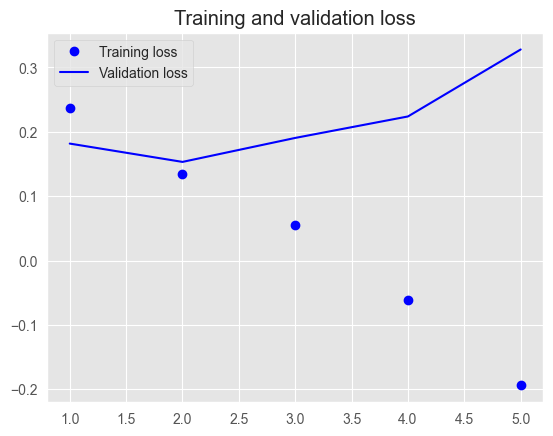

In [32]:
acc = history_RNN.history['acc']
val_acc = history_RNN.history['val_acc']
loss = history_RNN.history['loss']
val_loss = history_RNN.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [33]:
model.evaluate(x_test, y_test)

184/184 [==============================] - 1s 7ms/step - loss: 0.2613 - acc: 0.9457


[0.261324018239975, 0.9456743597984314]

## Prediction of Recommended IND[](http://)

In [34]:
# BASELINE
# That is, if all the labels are predicted as 1
(np.sum(df['Recommended IND'] == 1)/df.shape[0]) * 100

# we have to make model that performs better than this baseline

82.23622583666865

### Naive Bayes Classifier

In [35]:
def create_dict(tokenized_list):
    my_dict = dict([(word, True) for word in tokenized_list])
    return my_dict
df["NBCdata"] = df["tokenized"].apply(create_dict)
r_data = df["NBCdata"].values
reviews_labels = df["Recommended IND"].values


In [36]:
reviews_data = []
for i in range(len(r_data)):
    reviews_data.append([r_data[i], reviews_labels[i]])

In [37]:
train_data = reviews_data[:18788]
test_data = reviews_data[18788:]

In [38]:
classifier = NaiveBayesClassifier.train(train_data)

In [39]:
classifier.show_most_informative_features()

Most Informative Features
                disaster = True                0 : 1      =     35.5 : 1.0
               defective = True                0 : 1      =     32.5 : 1.0
                  poorly = True                0 : 1      =     28.2 : 1.0
            additionally = True                0 : 1      =     23.2 : 1.0
                 bizarre = True                0 : 1      =     23.2 : 1.0
              unwearable = True                0 : 1      =     21.9 : 1.0
                   awful = True                0 : 1      =     18.7 : 1.0
                    blah = True                0 : 1      =     18.0 : 1.0
                 dressed = True                1 : 0      =     17.9 : 1.0
                 annoyed = True                0 : 1      =     17.0 : 1.0


In [40]:
accuracy = nltk.classify.util.accuracy(classifier, test_data)
print("Classification Accuracy for Recommendation is...")
print(accuracy * 100)

Classification Accuracy for Recommendation is...
85.52575564069816


### Deep Neural Network Classifier

In [41]:
# Deep learning models
labels = np.asarray(df["Recommended IND"].values)
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: validation_samples] 
y_val = labels[training_samples: validation_samples]
x_test = data[validation_samples:]
y_test = labels[validation_samples:]
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

In [42]:
model = build_model()
model.summary()
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save("model2.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                640064    
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1642177 (6.26 MB)
Trainable params: 1642177 (6.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
367/36

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


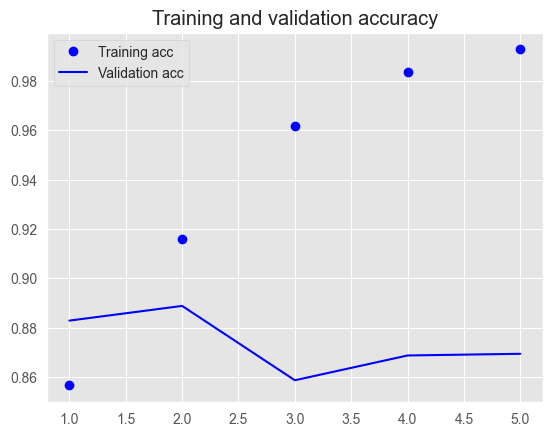

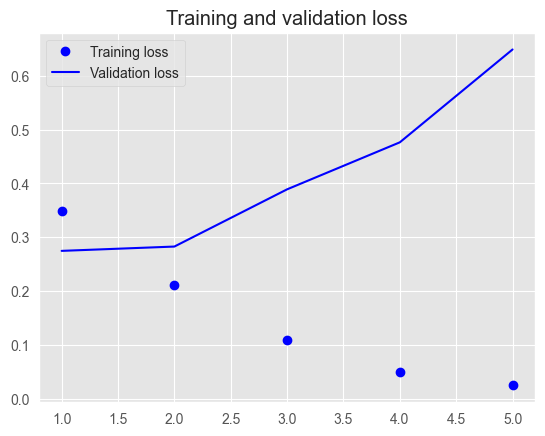

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [44]:
model.evaluate(x_test, y_test)

184/184 [==============================] - 1s 3ms/step - loss: 0.6983 - acc: 0.8518


[0.6983160972595215, 0.8518392443656921]

In [45]:
model = build_RNN()
model.summary()
history_RNN = model.fit(x_train, y_train,
                    epochs=2,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save("model_RNN2.h5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1004289 (3.83 MB)
Trainable params: 1004289 (3.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
367/367 [==============================] - 11s 27ms/step - loss: 0.3649 - acc: 0.8510 - val_loss: 0.3257 - val_acc: 0.8688
Epoch 2/2
367/367 [==============================] - 10s 26ms/step - loss: 0.2361 - acc: 0.9068 - val_loss: 0.2782 - val_acc: 0.8849


C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


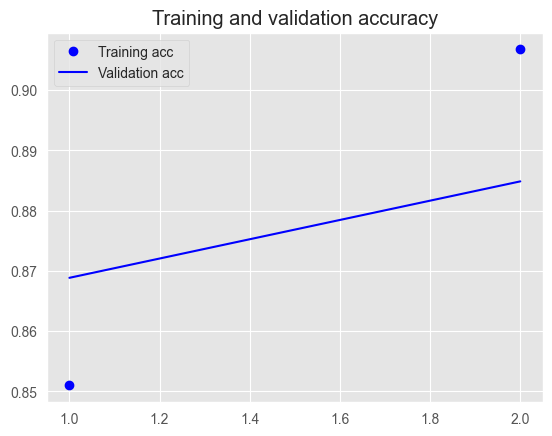

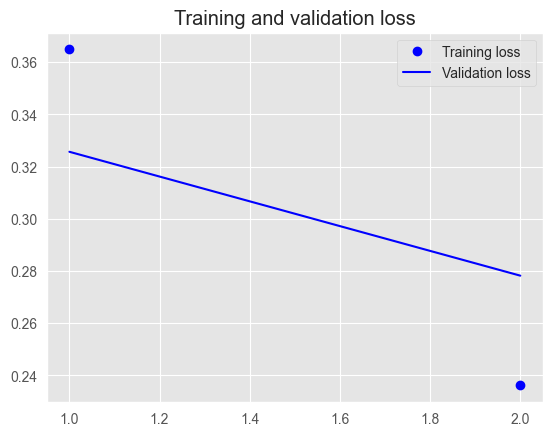

In [46]:
acc = history_RNN.history['acc']
val_acc = history_RNN.history['val_acc']
loss = history_RNN.history['loss']
val_loss = history_RNN.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [47]:
model.evaluate(x_test, y_test)

184/184 [==============================] - 1s 7ms/step - loss: 0.2903 - acc: 0.8813


[0.29028254747390747, 0.8813011050224304]